### Forecasting using LSTM from Keras

Steps: 
1. Transform the dataset to make it suitable for the LSTM model, including:
    - Transforming the data to a supervised learning problem.
    - Transforming the data to be stationary.
    - Transforming the data so that it has the scale -1 to 1.
2. Fitting a stateful LSTM network model to the training data.
3. Evaluating the static LSTM model on the test data.
4. Report the performance of the forecasts.

In [1]:
import pandas as pd
from pandas import DataFrame, Series
from pandas import concat
import numpy as np
from LSTM_cc import *

In [3]:
cg = pd.read_csv('climate_change2013.csv',index_col='Date',parse_dates = True)
cg.index.freq='MS'

In [4]:
#SURFACE TEMPERATURE
surf_t = cg['surface_temp']
surf_t = surf_t.to_frame()

#CO2
co2 = cg['surface_temp']
co2 = co2.to_frame()

rain_days = cg['no_of_rainy_days']
rain_days = rain_days.to_frame()

rainfall = cg['total_rainfall']
rainfall = rainfall.to_frame()

humidity = cg['relative_humidity']
humidity = humidity.to_frame()

gmsl = cg['GMSL(Global Mean Sea Level)']
gmsl = gmsl.to_frame()

land_ocean_temp = cg['Anomalies_Land_Ocean_Temperature']
land_ocean_temp = land_ocean_temp.to_frame()

#### 1) Transform Time Series to Supervised Learning

The LSTM model in Keras assumes that the data is divided into input (X) and output (y) components so i'll use the observation from the last time step (t-1) as the input and the observation at the current time step (t) as the output.

To do so i'll use the shift() function in Pandas that will push all values in a series down by a specified number places, in this case 1 place that will become the input variables. The time series as it stands will be the output variables.

Then I concatenate these two series together to create a DataFrame ready for supervised learning. The pushed-down series will have a new position at the top with no value. A NaN value will be used in this position. These NaN values will replace with 0 values, which the LSTM model will have to learn as “the start of the series” or “I have no data here,” as a month with zero observation.

### 2) Transform Time Series to Stationary

A dataset non stationary implies the presence of a structure in the data that is dependent on the time, so there is an increasing trend in the data. I need to make this data stationary because it's easy to model.

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

A standard way to remove a trend is by differencing the data (like i already did for the VARMA model)


In [5]:
# transform data to be stationary
raw_values = surf_t.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:] #the last 12 months (1 year) will be used for the test set
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In order to develop a robust result, i fix a number seed used by Keras to ensure the results are reproducible. So i can repeat the experiment from the previous section multiple times, then take the average RMSE as an indication of how well the configuration would be expected to perform on unseen data on average.

To do it i wrap the model fitting and walk-forward validation in a loop of fixed number of repeats (10). Each iteration the RMSE of the run can be recorded and use to summarize the distribution of RMSE scores.

            rmse
count  10.000000
mean    0.760703
std     0.168217
min     0.684100
25%     0.691994
50%     0.705623
75%     0.723724
max     1.234435


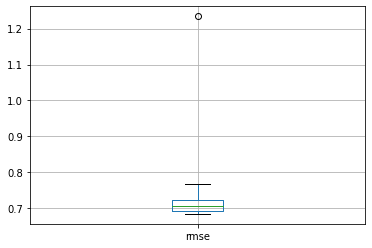

In [14]:
# summarize results
results = DataFrame()
results['rmse'] = robust_lstm(train_scaled,test_scaled,scaler,raw_values)[0]
print(results.describe())
results.boxplot()
plt.show()

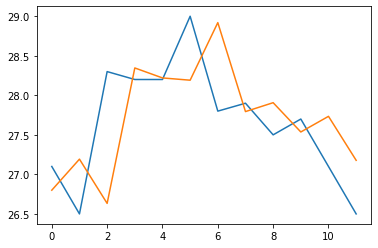

In [15]:
# line plot of observed vs predicted
pred = robust_lstm(train_scaled,test_scaled,scaler,raw_values)[1]
plt.plot(raw_values[-12:])
plt.plot(pred)
plt.show()